## Data pipeline using `tf.data` and a directory of images

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

%matplotlib inline
from IPython.core.pylabtools import figsize

Start with a list of file paths to images and an array of corresponding labels.

In [2]:
imdir = "/home/joe/Desktop/photos for kevin/"
images = [imdir+x for x in os.listdir(imdir)]

In [3]:
labels = np.random.choice([0,1], size=len(images))
labels

array([1, 0, 1, 1, 0, 1])

Write two functions using *only* tensorflow functions:

* one to read, parse, and reshape images
* one to do our augmentation

Note that they each input and output a tuple- the actual image data (x) and a label (y) that will be propagated alongside it.

In [4]:
def load(x, y):
    filestring = tf.read_file(x)
    img = tf.image.decode_jpeg(filestring)
    img_4d = tf.expand_dims(img, 0)
    img_resized_4d = tf.image.resize_bicubic(img_4d, [224, 224])
    img_resized = tf.squeeze(img_resized_4d)
    return img_resized, y

def augment(x, y):
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.1, 0.9)
    x = tf.image.random_flip_left_right(x)
    return x, y

In [5]:
tf.reset_default_graph()

Initialize a `Dataset` using the file paths and labels, then use `map` to call our load and augment functions. We can use `num_parallel_calls` to run this function more than once in parallel.

In [6]:
ds = tf.data.Dataset.from_tensor_slices((images, labels))

ds = ds.map(load, num_parallel_calls=2)
ds = ds.map(augment)
ds = ds.repeat()
ds = ds.shuffle(20)
ds = ds.batch(9)

batch = ds.make_one_shot_iterator().get_next()

The output of this multithreaded pipeline will be a tuple of two tensors that we can plug into the tensorflow graph:

In [7]:
batch

(<tf.Tensor 'IteratorGetNext:0' shape=(?, ?, ?, ?) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int64>)

Let's pull a batch and take a look:

In [8]:
with tf.Session() as sess:
    result = sess.run(batch)

In [9]:
result[0].shape

(9, 224, 224, 3)

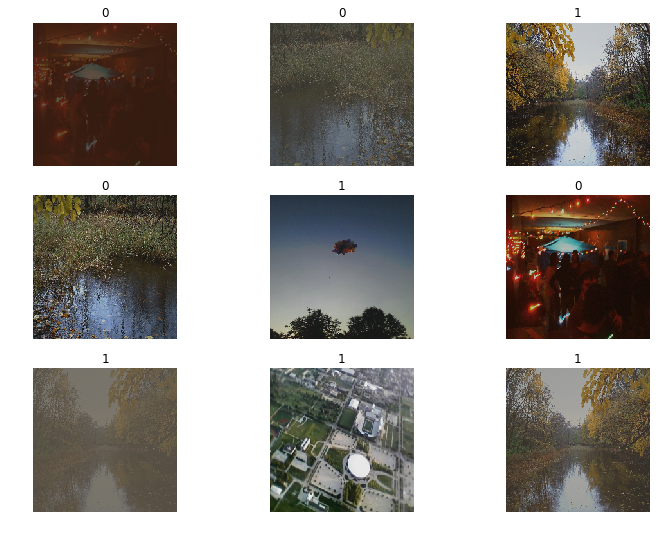

In [10]:
figsize(12, 9)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(result[0][i,:,:,:].astype(np.uint8))
    plt.title(result[1][i])
    plt.axis("off");